In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
%cd /content/gdrive/My Drive/Data_88_Project

/content/gdrive/My Drive/Data_88_Project


In [20]:
!ls

chr1.geno	   chrM.geno		       HGDP-CEPH-ID_populations.csv
chr22_CEU_YRI.csv  Data88_Project_AC_SN.ipynb


# Clustering based on Mitochondrial SNPs

## 1 - Introduction:

In 2008, several papers were published documenting the relavance of using PCA to cluster populations using SNP data. One of these papers *Worldwide Human Relationships Inferred from Genome-Wide Patterns of Variation* by Li et al, examined more than 650,000 SNPs in samples from the Human Genome Diversity Panel (link to paper below). Figures such as the one below, reveal surprising connections between PCA space and geographical location. 
![alt text][logo]

[logo]: https://science.sciencemag.org/content/sci/319/5866/1100/F2.large.jpg

The authors of this paper have made their data publicly available (see below), and in this notebook we want to replicate PCA plots like the one above using mitochondrial SNPs. Mitochondrial SNPs are interesting because mitochondrial DNA has a higher mutation rate compared to nuclear DNA, and so should be very informative in clustering populations.

Links:
- Data:
http://www.cephb.fr/en/hgdp_panel.php#basedonnees
ftp://ftp.cephb.fr/hgdp_supp1/
- Paper:
https://science.sciencemag.org/content/319/5866/1100/tab-figures-data
https://science.sciencemag.org/content/sci/suppl/2008/02/21/319.5866.1100.DC1/Li_SOM.pdf


## 2 - Preprocessing

In [0]:
#Loading Metadata
metadata = pd.read_csv("HGDP-CEPH-ID_populations.csv")[["CEPH ID", "Region", "population", "Geographic origin", "Pop7Groups"]]

In [0]:
#Filtering metadata
middle_east_metadata = metadata[metadata["population"].isin(["Bedouin", "Druze", "Mozabite", "Palestinian"])]
european_metadata = metadata[metadata["population"].isin(["Adygei", "Basque", "French", "Italian", "Orcadian", "Russian", "Sardinian", "Tuscan"])]

In [121]:
#Finding Region labels for each of our samples
_ = pd.DataFrame({"IDS": chrM_df.columns.values})
mito_labels = _.set_index("IDS").join(metadata.set_index("CEPH ID")[["Region", "Pop7Groups", "population"]], how = "inner") 
mito_labels

,Region,Pop7Groups,population
HGDP00448,Subsaharan Africa,Africa,Biaka_Pygmy
HGDP00479,Subsaharan Africa,Africa,Biaka_Pygmy
HGDP00985,Subsaharan Africa,Africa,Biaka_Pygmy
HGDP01094,Subsaharan Africa,Africa,Biaka_Pygmy
HGDP00982,Subsaharan Africa,Africa,Mbuti_Pygmy
...,...,...,...
HGDP00953,Asia,Est_Asia,Yakut
HGDP01070,Europe,Europe,Sardinian
HGDP01376,Europe,Europe,French_Basque
HGDP00671,Europe,Europe,Sardinian


In [122]:
#Raw SNP data & some pre-processing
chrM_df = pd.read_csv("chrM.geno", sep='\t').iloc[:,1:]
chrM_df = chrM_df.drop('HGDP00597', axis=1) #this sample was not included in the metadata so we dropped it
chrM_df.head()

,HGDP00448,HGDP00479,HGDP00985,HGDP01094,HGDP00982,HGDP00911,HGDP01202,HGDP00927,HGDP00461,HGDP00451,HGDP00986,HGDP00449,HGDP00983,HGDP00912,HGDP01283,HGDP00928,HGDP00937,HGDP01408,HGDP00991,HGDP01031,HGDP01263,HGDP01275,HGDP00611,HGDP00623,HGDP00634,HGDP00645,HGDP00557,HGDP00569,HGDP00581,HGDP00594,HGDP00675,HGDP00687,HGDP00697,HGDP00729,HGDP00741,HGDP00011,HGDP00035,HGDP00058,HGDP00082,HGDP00103,...,HGDP00867,HGDP01403,HGDP00888,HGDP00900,HGDP01044,HGDP01056,HGDP00860,HGDP00872,HGDP00706,HGDP00901,HGDP01045,HGDP01057,HGDP00861,HGDP00873,HGDP00707,HGDP01404,HGDP00889,HGDP01151,HGDP01330,HGDP00528,HGDP00719,HGDP01161,HGDP00828,HGDP00965,HGDP00516,HGDP01365,HGDP00766,HGDP00657,HGDP01354,HGDP00798,HGDP01342,HGDP00824,HGDP01319,HGDP01357,HGDP00549,HGDP00953,HGDP01070,HGDP01376,HGDP00671,HGDP01024
0,TT,CC,TT,TT,CC,TT,TT,TT,TT,CC,--,CC,TT,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,...,CC,CC,CC,CC,CC,CC,CC,--,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC
1,--,TT,TT,--,TT,TT,TT,TT,--,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,CC,TT,TT,...,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT
2,GG,GG,--,GG,--,GG,GG,GG,GG,GG,GG,--,GG,GG,GG,GG,GG,GG,--,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,...,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG
3,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,GG,GG,GG,GG,GG,GG,AA,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG,--,...,GG,GG,GG,GG,--,--,GG,GG,--,GG,--,--,GG,GG,GG,GG,GG,GG,--,GG,GG,GG,GG,--,GG,GG,--,GG,GG,GG,GG,GG,--,GG,GG,--,GG,GG,GG,GG
4,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,...,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT


In [0]:
#Encoding SNP datamatrix. Most frequent SNP across samples --> 2. 2nd most common SNP across samples --> 1. Other --> 0.
for row in np.arange(chrM_df.shape[0]):
  freq = chrM_df.iloc[row].value_counts().sort_values(ascending=False)
  counter = 2
  for i in freq.index:
    chrM_df.iloc[row].replace(i, counter, inplace=True)
    if counter != 0:
      counter -=1

In [124]:
chrM_df

,HGDP00448,HGDP00479,HGDP00985,HGDP01094,HGDP00982,HGDP00911,HGDP01202,HGDP00927,HGDP00461,HGDP00451,HGDP00986,HGDP00449,HGDP00983,HGDP00912,HGDP01283,HGDP00928,HGDP00937,HGDP01408,HGDP00991,HGDP01031,HGDP01263,HGDP01275,HGDP00611,HGDP00623,HGDP00634,HGDP00645,HGDP00557,HGDP00569,HGDP00581,HGDP00594,HGDP00675,HGDP00687,HGDP00697,HGDP00729,HGDP00741,HGDP00011,HGDP00035,HGDP00058,HGDP00082,HGDP00103,...,HGDP00867,HGDP01403,HGDP00888,HGDP00900,HGDP01044,HGDP01056,HGDP00860,HGDP00872,HGDP00706,HGDP00901,HGDP01045,HGDP01057,HGDP00861,HGDP00873,HGDP00707,HGDP01404,HGDP00889,HGDP01151,HGDP01330,HGDP00528,HGDP00719,HGDP01161,HGDP00828,HGDP00965,HGDP00516,HGDP01365,HGDP00766,HGDP00657,HGDP01354,HGDP00798,HGDP01342,HGDP00824,HGDP01319,HGDP01357,HGDP00549,HGDP00953,HGDP01070,HGDP01376,HGDP00671,HGDP01024
0,1,2,1,1,2,1,1,1,1,2,0,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1,1,2,2,1,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,2,2,1,2,1,2,2,2,2,2,2,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,...,2,2,2,2,1,1,2,2,1,2,1,1,2,2,2,2,2,2,1,2,2,2,2,1,2,2,1,2,2,2,2,2,1,2,2,1,2,2,2,2
4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,2,1,1,2,2,0,0,0,1,1,1,2,1,1,2,2,2,2,1,2,2,2,2,2,1,1,2,1,2,2,2,2,1,2,1,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,1,0,2,2,2,2,1,1,2,2,2,2,2,1,2,0,2,2,2,2,1,1
159,0,1,0,0,2,0,1,1,0,1,2,2,0,1,1,1,2,0,2,1,2,2,2,2,1,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
160,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,1,1,2,2,0,2,1,1,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2
161,2,2,2,2,1,2,2,2,2,2,2,1,1,2,1,1,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2


## 2.1 - Repeating their clustering of middle east data

In [133]:
#Filter and get rid of missing data
middle_east_data = chrM_df[[x for x in chrM_df.columns.values if x in middle_east_metadata["CEPH ID"].values]] 
middle_east_metadata = middle_east_metadata[middle_east_metadata["CEPH ID"].isin([x for x in chrM_df.columns.values if x in middle_east_metadata["CEPH ID"].values])]
middle_east_data.head()

,HGDP01263,HGDP01275,HGDP00611,HGDP00623,HGDP00634,HGDP00645,HGDP00557,HGDP00569,HGDP00581,HGDP00594,HGDP00675,HGDP00687,HGDP00697,HGDP00729,HGDP00741,HGDP01264,HGDP01276,HGDP00612,HGDP00624,HGDP00635,HGDP00646,HGDP00558,HGDP00570,HGDP00582,HGDP00595,HGDP00676,HGDP00688,HGDP00698,HGDP00730,HGDP00742,HGDP01253,HGDP01265,HGDP01277,HGDP00613,HGDP00636,HGDP00647,HGDP00559,HGDP00571,HGDP00583,HGDP00677,...,HGDP01274,HGDP00610,HGDP00622,HGDP00568,HGDP00580,HGDP00592,HGDP00606,HGDP00699,HGDP00731,HGDP00743,HGDP00700,HGDP00732,HGDP00744,HGDP00722,HGDP00733,HGDP00745,HGDP00723,HGDP00734,HGDP00746,HGDP00724,HGDP00735,HGDP00740,HGDP00726,HGDP00737,HGDP00625,HGDP01260,HGDP01272,HGDP00608,HGDP00620,HGDP00632,HGDP01258,HGDP01270,HGDP01282,HGDP00618,HGDP00630,HGDP01261,HGDP01273,HGDP00609,HGDP00621,HGDP00633
0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,0,2,2
1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2
3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,0,2
4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2


In [0]:
#PCA and t-SNE using sklearn
pca_mito_me = PCA(n_components=5)
mito_pcs_me = pca_mito_me.fit_transform(middle_east_data.values.T)

In [135]:
#labels
middle_east_labels = middle_east_metadata.set_index("CEPH ID")['population']
middle_east_labels.unique()

array(['Druze', 'Bedouin', 'Palestinian', 'Mozabite'], dtype=object)

Text(0.5, 1.0, 'Projection of Middle East Data')

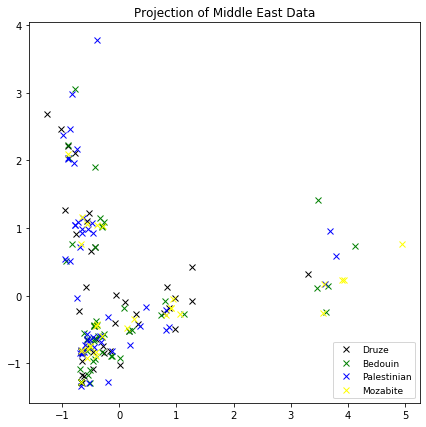

In [136]:
plt.figure(figsize=(7,7))
plt.plot(mito_pcs_me[middle_east_labels=='Druze',0], mito_pcs_me[middle_east_labels=='Druze',1], 'x', c = 'black')
plt.plot(mito_pcs_me[middle_east_labels=='Bedouin',0], mito_pcs_me[middle_east_labels=='Bedouin',1], 'x', c = 'green')
plt.plot(mito_pcs_me[middle_east_labels=='Palestinian',0], mito_pcs_me[middle_east_labels=='Palestinian',1], 'x', c = 'blue')
plt.plot(mito_pcs_me[middle_east_labels=='Mozabite',0], mito_pcs_me[middle_east_labels=='Mozabite',1], 'x', c = 'yellow')
plt.legend(['Druze', 'Bedouin', 'Palestinian', 'Mozabite'], loc = "lower right", prop={'size': 9})
plt.title('Projection of Middle East Data')

## 2.2 - Repeating their clustering of European data

In [137]:
#Filter and get rid of missing data
europe_data = chrM_df[[x for x in chrM_df.columns.values if x in european_metadata["CEPH ID"].values]]
european_metadata = european_metadata[european_metadata["CEPH ID"].isin([x for x in chrM_df.columns.values if x in european_metadata["CEPH ID"].values])]
europe_data.head()

,HGDP00521,HGDP00533,HGDP00667,HGDP01066,HGDP01078,HGDP00794,HGDP00806,HGDP00522,HGDP00534,HGDP00668,HGDP01067,HGDP01079,HGDP00795,HGDP00807,HGDP00511,HGDP00523,HGDP00535,HGDP00669,HGDP01068,HGDP00796,HGDP00808,HGDP00512,HGDP00524,HGDP00536,HGDP00513,HGDP00525,HGDP00537,HGDP00514,HGDP00526,HGDP00538,HGDP01063,HGDP01075,HGDP01167,HGDP00803,HGDP01385,HGDP00515,HGDP00527,HGDP00539,HGDP01388,HGDP00880,...,HGDP01386,HGDP01396,HGDP00881,HGDP00893,HGDP01397,HGDP00882,HGDP00894,HGDP01399,HGDP00884,HGDP00896,HGDP00518,HGDP00530,HGDP01400,HGDP00885,HGDP00897,HGDP00670,HGDP01069,HGDP00797,HGDP00810,HGDP01401,HGDP00886,HGDP00898,HGDP01402,HGDP00887,HGDP00899,HGDP01398,HGDP00883,HGDP00895,HGDP01403,HGDP00888,HGDP00900,HGDP00901,HGDP01404,HGDP00889,HGDP00528,HGDP01161,HGDP00516,HGDP00798,HGDP01070,HGDP00671
0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,1,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [0]:
#PCA and t-SNE using sklearn
pca_mito_euro = PCA(n_components=5)
mito_pcs_euro = pca_mito_me.fit_transform(europe_data.values.T)

In [139]:
#labels
europe_labels = european_metadata.set_index("CEPH ID")['population']
europe_labels.unique()

array(['French', 'Sardinian', 'Orcadian', 'Russian', 'Tuscan', 'Adygei'],
      dtype=object)

Text(0.5, 1.0, 'Projection of European Data')

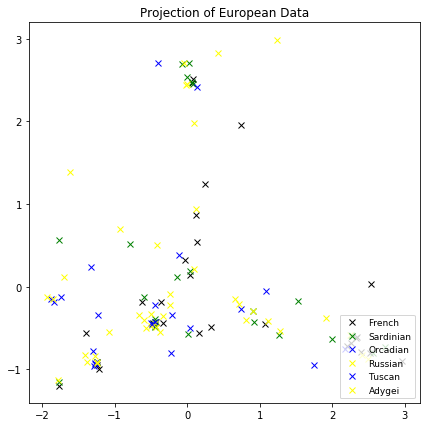

In [140]:
plt.figure(figsize=(7,7))
plt.plot(mito_pcs_euro[europe_labels=='French',0], mito_pcs_euro[europe_labels=='French',1], 'x', c = 'black')
plt.plot(mito_pcs_euro[europe_labels=='Sardinian',0], mito_pcs_euro[europe_labels=='Sardinian',1], 'x', c = 'green')
plt.plot(mito_pcs_euro[europe_labels=='Orcadian',0], mito_pcs_euro[europe_labels=='Orcadian',1], 'x', c = 'blue')
plt.plot(mito_pcs_euro[europe_labels=='Russian',0], mito_pcs_euro[europe_labels=='Russian',1], 'x', c = 'yellow')
plt.plot(mito_pcs_euro[europe_labels=='Tuscan',0], mito_pcs_euro[europe_labels=='Tuscan',1], 'x', c = 'blue')
plt.plot(mito_pcs_euro[europe_labels=='Adygei',0], mito_pcs_euro[europe_labels=='Adygei',1], 'x', c = 'yellow')
plt.legend(['French', 'Sardinian', 'Orcadian', 'Russian', 'Tuscan', 'Adygei'], loc = "lower right", prop={'size': 9})
plt.title('Projection of European Data')

## 2.3 - Clustering all data

In [0]:
#PCA and t-SNE using sklearn
pca_mito = PCA(n_components=5)
mito_pcs = pca_mito.fit_transform(chrM_df.values.T)
mito_comps = pca_mito.components_
tsne_mito = TSNE(n_components = 2)
mito_embedded = tsne_mito.fit_transform(mito_pcs)

In [142]:
mito_pcs.shape # Datamatrix reduced to PCA space

(1042, 5)

In [143]:
mito_comps.shape #Principal axes in feature space

(5, 163)

In [144]:
mito_embedded.shape #Data in tSNE space

(1042, 2)

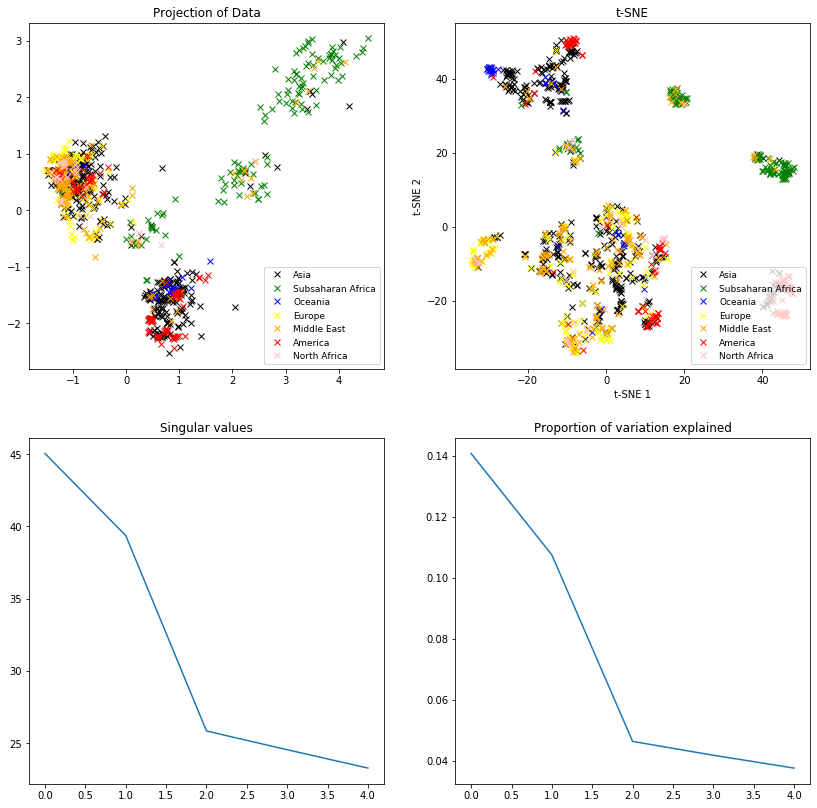

In [145]:
# Perhaps we can look at finer labels for Asia and America because it seems like there's two distinct sub-populations
plt.figure(figsize=(14,14))
plt.subplot(221)
plt.plot(mito_pcs[mito_labels.iloc[:,0]=='Asia',0], mito_pcs[mito_labels.iloc[:,0]=='Asia',1], 'x', c = 'black')
plt.plot(mito_pcs[mito_labels.iloc[:,0]=='Subsaharan Africa',0], mito_pcs[mito_labels.iloc[:,0]=='Subsaharan Africa',1], 'x', c = 'green')
plt.plot(mito_pcs[mito_labels.iloc[:,0]=='Oceania',0], mito_pcs[mito_labels.iloc[:,0]=='Oceania',1], 'x', c = 'blue')
plt.plot(mito_pcs[mito_labels.iloc[:,0]=='Europe',0], mito_pcs[mito_labels.iloc[:,0]=='Europe',1], 'x', c = 'yellow')
plt.plot(mito_pcs[mito_labels.iloc[:,0]=='Middle East',0], mito_pcs[mito_labels.iloc[:,0]=='Middle East',1], 'x', c = 'orange')
plt.plot(mito_pcs[mito_labels.iloc[:,0]=='America',0], mito_pcs[mito_labels.iloc[:,0]=='America',1], 'x', c = 'red')
plt.plot(mito_pcs[mito_labels.iloc[:,0]=='North Africa',0], mito_pcs[mito_labels.iloc[:,0]=='North Africa',1], 'x', c = 'pink')
plt.legend(['Asia', 'Subsaharan Africa', 'Oceania', 'Europe', 'Middle East','America', 'North Africa'], loc = "lower right", prop={'size': 9})
plt.title('Projection of Data')

plt.subplot(222)
plt.plot(mito_embedded[mito_labels.iloc[:,0]=='Asia',0], mito_embedded[mito_labels.iloc[:,0]=='Asia',1], 'x', c = 'black')
plt.plot(mito_embedded[mito_labels.iloc[:,0]=='Subsaharan Africa',0], mito_embedded[mito_labels.iloc[:,0]=='Subsaharan Africa',1], 'x', c = 'green')
plt.plot(mito_embedded[mito_labels.iloc[:,0]=='Oceania',0], mito_embedded[mito_labels.iloc[:,0]=='Oceania',1], 'x', c = 'blue')
plt.plot(mito_embedded[mito_labels.iloc[:,0]=='Europe',0], mito_embedded[mito_labels.iloc[:,0]=='Europe',1], 'x', c = 'yellow')
plt.plot(mito_embedded[mito_labels.iloc[:,0]=='Middle East',0], mito_embedded[mito_labels.iloc[:,0]=='Middle East',1], 'x', c = 'orange')
plt.plot(mito_embedded[mito_labels.iloc[:,0]=='America',0], mito_embedded[mito_labels.iloc[:,0]=='America',1], 'x', c = 'red')
plt.plot(mito_embedded[mito_labels.iloc[:,0]=='North Africa',0], mito_embedded[mito_labels.iloc[:,0]=='North Africa',1], 'x', c = 'pink')
plt.legend(['Asia', 'Subsaharan Africa', 'Oceania', 'Europe', 'Middle East','America', 'North Africa'], loc = "lower right", prop={'size': 9})
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE')

plt.subplot(223)
plt.plot(pca_mito.singular_values_)
plt.title('Singular values')

plt.subplot(224)
plt.plot(pca_mito.explained_variance_ratio_)
plt.title('Proportion of variation explained')

plt.show()

Text(0.5, 0.92, 'Projection of Data')

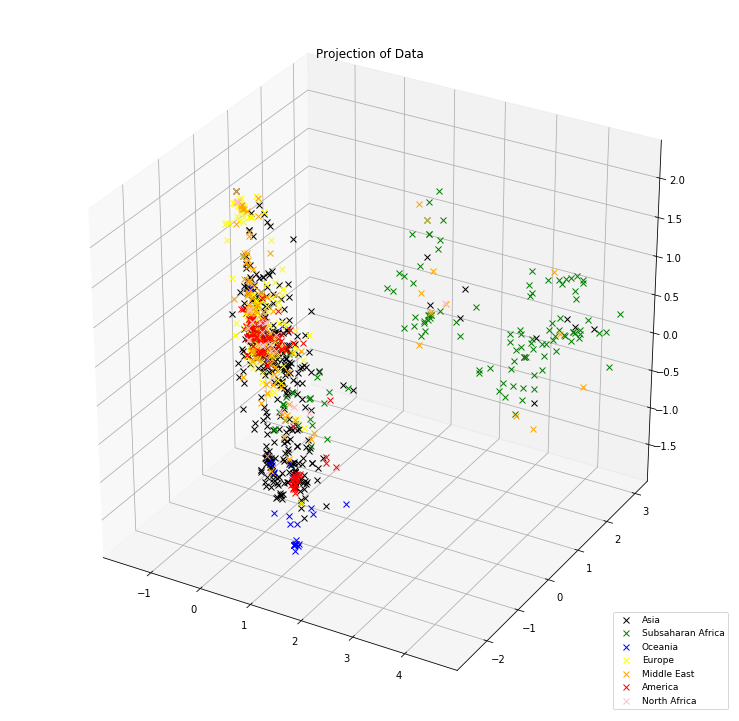

In [146]:
# Data in 3D PCA space
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(13,13))
ax = plt.axes(projection="3d")
ax.plot(mito_pcs[mito_labels.iloc[:,0]=='Asia',0], mito_pcs[mito_labels.iloc[:,0]=='Asia',1], mito_pcs[mito_labels.iloc[:,0]=='Asia',2], 'x', c = 'black')
ax.plot(mito_pcs[mito_labels.iloc[:,0]=='Subsaharan Africa',0], mito_pcs[mito_labels.iloc[:,0]=='Subsaharan Africa',1],mito_pcs[mito_labels.iloc[:,0]=='Subsaharan Africa',2], 'x', c = 'green')
ax.plot(mito_pcs[mito_labels.iloc[:,0]=='Oceania',0], mito_pcs[mito_labels.iloc[:,0]=='Oceania',1], mito_pcs[mito_labels.iloc[:,0]=='Oceania',2],'x', c = 'blue')
ax.plot(mito_pcs[mito_labels.iloc[:,0]=='Europe',0], mito_pcs[mito_labels.iloc[:,0]=='Europe',1], mito_pcs[mito_labels.iloc[:,0]=='Europe',2],'x', c = 'yellow')
ax.plot(mito_pcs[mito_labels.iloc[:,0]=='Middle East',0], mito_pcs[mito_labels.iloc[:,0]=='Middle East',1], mito_pcs[mito_labels.iloc[:,0]=='Middle East',2],'x', c = 'orange')
ax.plot(mito_pcs[mito_labels.iloc[:,0]=='America',0], mito_pcs[mito_labels.iloc[:,0]=='America',1], mito_pcs[mito_labels.iloc[:,0]=='America',2], 'x', c = 'red')
ax.plot(mito_pcs[mito_labels.iloc[:,0]=='North Africa',0], mito_pcs[mito_labels.iloc[:,0]=='North Africa',1],mito_pcs[mito_labels.iloc[:,0]=='North Africa',2], 'x', c = 'pink')
ax.legend(['Asia', 'Subsaharan Africa', 'Oceania', 'Europe', 'Middle East','America', 'North Africa'], loc = "lower right", prop={'size': 9})
ax.set_title('Projection of Data')


# Results:
Repeating the analysis in Li et al., the projection of individuals from middle east, and from Europe into PCA space fails to resolve differeneces between sub-populations. This suggests that Mitochondrial SNPs are insufficient at resolving population differences for these samples.

Projecting individuals from the entire dataset into PCA space yields better separation of poulations. From the PCA plots in 2.3, it seems like subsaharan individuals form a distinct cluster in PCA space, and that other populations colocalize in two clusters. Additionally, it seems like there are two clusters for Asian individuals, and two clusters for American individuals. This suggests that further division of population labels may better resolve the differences between these two clusters.